# Data Science - Laboratorio 6
## Minería de Texto: Análisis de Sentimientos
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -
## Ejercicio 1 - Disaster Tweets

## Librerias

NOTA: Importante tener el Token de la API en el folder "C:\Users\<Windows-username>\.kaggle\kaggle.json"

Para una guia mas detallada o si tiene otro sistema dirigase a: https://www.kaggle.com/docs/api#getting-started-installation-&-authentication 

Asimismo puede visitar la documentacion oficial de la API: https://github.com/Kaggle/kaggle-api/tree/main/docs#api-credentials

In [1]:
# Kaggle API
import kaggle
from kaggle.rest import ApiException

# Operaciones con archivos
import os
import zipfile

# Operaciones con datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
from wordcloud import WordCloud

# Procesamiento de lengauje natural
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Modelado y evaluación
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Utilidades
from collections import Counter

## Carga de Dataset

### Descargar el archivo con Kaggle

Puede omitir esta celda si decide descargar los archivos manualmente desde https://www.kaggle.com/c/nlp-getting-started/data

In [2]:
# Autenticación con Kaggle API
kaggle.api.authenticate()

# Definir competencia y directorio de descarga
competition_name = 'nlp-getting-started'
target_path = 'data'

# Verificar si existen archivos descargados previamente
if  not os.path.exists(f"{target_path}/ej1-train.csv"):
    # Descargar archivos de la competencia
    try:
        kaggle.api.competition_download_files(competition='nlp-getting-started',
                                            path='data',
                                            quiet=False,
                                            force=False)
        
        print(f"EXITO: Archivos descargados en '{target_path}'")

    except ApiException as e:
        print(f"ERROR al llamar KaggleApi -> competition_download \n\t{e}")
        print("Puede que necesite aceptar las reglas de la competencia en https://www.kaggle.com/c/nlp-getting-started/rules")
else:
    print("AVISO: Se encontraron archivos descargados previamente")
    print(f"\tSi desea descargar nuevamente los archivos, elimine '{target_path}/{competition_name}.zip'")

AVISO: Se encontraron archivos descargados previamente
	Si desea descargar nuevamente los archivos, elimine 'data/nlp-getting-started.zip'


### Descomprimir el Zip

Puede omitir esta celda si ya tiene los archivos descomprimidos

In [3]:
# Verificar si ya se descomprimieron los archivos .zip previamente
if  os.path.exists(f"{target_path}/ej1-train.csv"):
    print("AVISO: Se encontraron archivos descargados previamente")
    print("\tOmitiendo descompresión de archivos .zip")

# Descomprimir archivos .zip
else:
    try:
        # Verificar si se descargó un archivo .zip y descomprimirlo
        if os.path.exists(f"{target_path}/{competition_name}.zip"):
            # Descomprimir archivo .zip
            with zipfile.ZipFile(f'{target_path}/{competition_name}.zip', 'r') as zip_ref:
                zip_ref.extractall(target_path)
            
            # Renombrar archivos
            os.rename(f'{target_path}/train.csv', f'{target_path}/ej1-train.csv')

            # Eliminar archivo .zip
            os.remove(f'{target_path}/{competition_name}.zip')
            os.remove(f'{target_path}/sample_submission.csv')
            os.remove(f'{target_path}/test.csv')
            print(f"EXITO: Archivo .zip descomprimido en '{target_path}'")
        else:
            raise Exception(f"No se encontró archivo .zip en '{target_path}'")

    except Exception as e:
        print(f"ERROR al descomprimir archivo .zip \n\t{e}")

AVISO: Se encontraron archivos descargados previamente
	Omitiendo descompresión de archivos .zip


### Generar dataframes

In [4]:
# Cargar archivos en DataFrames
train_df = pd.read_csv('data/ej1-train.csv')

## Comprensión Inicial

### Información General del Dataset

In [5]:
def get_DF_info(df):
    """
    Función que genera un dataframe con información sobre las columnas de un dataframe dado.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        
    Returns:
        None
    """
    # Crear un dataframe con la información de las columnas    
    info = pd.DataFrame({
        'Nombre Columna': df.columns,
        'Tipo de Dato': df.dtypes,
        'Valores Nulos (%)': (df.isnull().sum() * 100 / df.shape[0]).round(2),
        'Valores Únicos': df.nunique(),
        'Valores Duplicados': df.duplicated().sum()
    }).reset_index(drop=True)

    # Mostrar la informacion
    print(f"\nEl dataframe tiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas (variables)\n")
    display(info)

In [6]:
print(f"Informacion del dataset: ej1-train.csv")
get_DF_info(df=train_df)

Informacion del dataset: ej1-train.csv

El dataframe tiene 7613 filas (registros) y 5 columnas (variables)



,Nombre Columna,Tipo de Dato,Valores Nulos (%),Valores Únicos,Valores Duplicados
0,id,int64,0.00,7613,0
1,keyword,object,0.80,221,0
2,location,object,33.27,3341,0
3,text,object,0.00,7503,0
4,target,int64,0.00,2,0


Como era de esperarse la variable `id` tiene un valor diferente por cada registro, por lo tanto no es relevante para esta práctica.

La variable objetivo `target` unicamente tiene 2 valores.

El conjunto de datos de entrenamiento tiene 2 variables que presentan valores nulos:
- `keyword`: Apenas un **0.8%** de los registros totales son nulos.
- `location`: Mas del **33%** de los registros totales son nulos.

Por lo tanto sera necesario analizar con detenimiento como manejar estas variables.

### Visualizar Dataframe

In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Identificación de Variables

- `id` - Un identificador unico para cada tweet.
- `text` - El texto del tweet.
- `location` - La ubicación desde donde fue enviado el tweet.
- `keyword` - Una palabre clave del tweet.
- `target` - Etiqueta que denota si un tweet es sobre un desastre real o no

## Preprocesamiento y Limpieza

### Valores Nulos

#### Verificación valores nulos

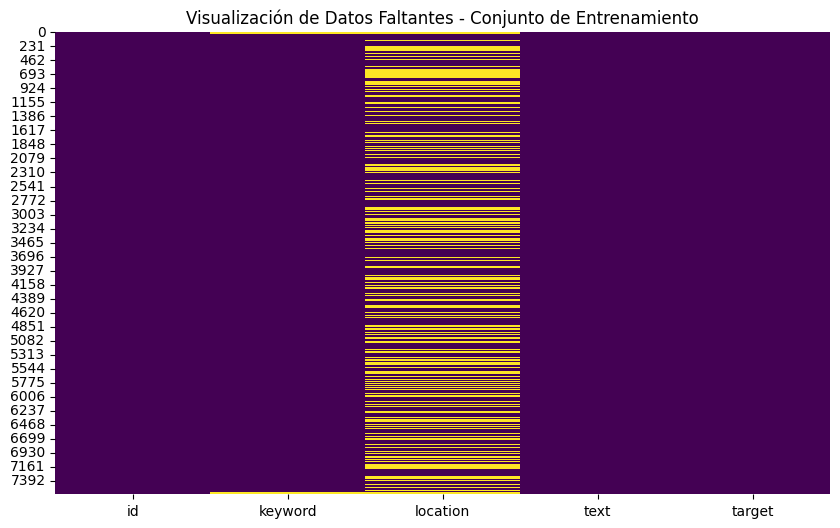

In [8]:
# Visualización de los datos faltantes en el conjunto de entrenamiento
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Visualización de Datos Faltantes - Conjunto de Entrenamiento")
plt.show()

Ese gráfico muestra que son muy pocos datos nulos en la variable `keyword`, sin embargo para la variable `location` si es mas visible la falta de datos corroborando que hay mas del 30% de datos nulos.

#### Análisis de Impacto de nulos

In [9]:
# Contar y calcular el porcentaje de registros conservados después de la eliminación de nulos
# Total de registros inicial
initial_count = train_df.shape[0]

# Eliminación de registros con valores nulos en keyword o location
dropna_keyword = train_df.dropna(subset=['keyword'])
dropna_location = train_df.dropna(subset=['location'])
dropna_both = train_df.dropna()

# Eliminación de registros con nulos en keyword, location, y ambos
dropna_keyword_count = dropna_keyword.shape[0]
dropna_location_count = dropna_location.shape[0]
dropna_both_count = dropna_both.shape[0]

# Cálculo de porcentajes conservados
dropna_keyword_pct = (dropna_keyword_count / initial_count) * 100
dropna_location_pct = (dropna_location_count / initial_count) * 100
dropna_both_pct = (dropna_both_count / initial_count) * 100

# Resultados del análisis
simplified_impact_analysis = pd.DataFrame({
    'Escenario': ['Original', 'Eliminando nulos de (keyword)', 'Eliminando nulos de (location)', 'Eliminando todos los nulos'],
    'Conteo': [initial_count, dropna_keyword_count, dropna_location_count, dropna_both_count],
    'Porcentaje conservado (%)': [100, dropna_keyword_pct, dropna_location_pct, dropna_both_pct]
})

display(simplified_impact_analysis)

,Escenario,Conteo,Porcentaje conservado (%)
0,Original,7613,100.000000
1,Eliminando nulos de (keyword),7552,99.198739
2,Eliminando nulos de (location),5080,66.727965
3,Eliminando todos los nulos,5080,66.727965


Estos resultados muestran que eliminar los registros nulos tiene un impacto significativo en el tamaño del conjunto de datos. Al eliminar los nulos de `location` desafortunadamente solo se convervan el 66% de los datos originales. Por lo tanto se ha decidido eliminar la variable ya que la imputación de valores no es una alternativa recomendable para este caso.

Por otro lado eliminar los registros nulos de `keyword` tienen un impacto de menos del 1%, por lo que es preferible preder ese ~1% que perder una variable entera con palabras clave de los tweets.

#### Manejo de Nulos

In [10]:
# Eliminar variable 'location'
train_df.drop(columns=['location'], inplace=True)

# Eliminar registros con valores nulos en 'keyword'
train_df.dropna(subset=['keyword'], inplace=True)

# Verificar si se eliminaron los registros con valores nulos
print("Datos faltantes en el conjunto de entrenamiento:")
print(train_df.isnull().sum())

Datos faltantes en el conjunto de entrenamiento:
id         0
keyword    0
text       0
target     0
dtype: int64


### Limpieza y Normalización de Texto

**Paso 1: Limpieza del Texto**
- Eliminar URLs: Los URLs no aportan valor en el contexto del análisis de texto para la clasificación de desastres.
- Eliminar caracteres especiales: Se eliminaran caracteres como #, @, y otros que no aportan semántica al contenido del texto.
- Eliminar emoticones: Similarmente, los emoticones no son relevantes para este análisis.

**Paso 2: Normalización del Texto**
- Convertir a minúsculas: Para evitar tratar palabras como diferentes si solo varían en el uso de mayúsculas o minúsculas.

**Paso 3: Eliminación de Palabras Vacías (Stopwords)**
- Eliminar palabras comunes: Palabras como `el`, `la`, `de`, `y`, etc., que no aportan valor en la clasificación.
- Eliminar terminos usados en twitter: como `RT`

**Paso 4: Conversión de palabras a su forma mas general (Stemming)**
- Stemming: Se obtiene la raiz de las palabras para que pasen a su forma mas general, esto para poder reducir significativamente el tamaño del vocabulario.

##### NOTA

En este análisis, se intentó utilizar lematización en lugar de stemming para el preprocesamiento de los textos. La idea detrás de la lematización era preservar el significado original de las palabras, reduciendo las palabras a su forma base o "lema". Esto permitiría capturar mejor el contexto semántico de cada tweet y mejorar el rendimiento de los modelos de clasificación.

**¿Por qué se intentó la lematización?**

- Mejor comprensión contextual: La lematización tiene la ventaja de mantener la precisión semántica. Por ejemplo, palabras como "running" se reducen a "run", preservando el sentido, mientras que el stemming podría cortar la palabra en una raíz poco representativa como "runn".
- Reducción adecuada del vocabulario: Al usar lemas en lugar de simples raíces de palabras, el objetivo era mantener una representación más precisa del texto, evitando sobre-reducciones que podrían afectar la interpretación de los tweets.

**Problemas encontrados con la lematización**

Durante la implementación de la lematización, se observó un aumento inesperado en la frecuencia de palabras inadecuadas o lenguaje soez. Al parecer, la lematización preservaba algunas formas coloquiales o vulgares de las palabras, las cuales no se reducían lo suficiente para ser filtradas en las etapas posteriores del preprocesamiento. Esto generó resultados indeseados, como la aparición de palabras ofensivas en los análisis de n-grams y en las listas de las palabras más comunes, lo que dificultó el análisis.

En un intento de mitigar este resultado no deseado, se integro censura del lenguaje ofensivo con la librería `alt-profanity-check` y `better-profanity`, librerías que detectaban y enmascaraban las palabras soeces. Sin embargo, los resultados tampoco fueron satisfactorios. Aunque los términos ofensivos se ocultaban parcialmente, esta estrategia no logró mejorar el rendimiento de los modelos de clasificación. De hecho, la censura afectó la capacidad del modelo para captar con precisión el tono y el contenido de los tweets.

**Decisión final**

Al ver que la lematización y la censura no proporcionaban mejoras en los modelos, se decidió regresar al stemming por varias razones:
- Simplicidad y eficacia: El stemming, aunque más agresivo, reduce las palabras a sus raíces de forma más consistente y rápida, ayudando a disminuir el ruido en los datos.
- Menor complejidad: A diferencia de la lematización, el stemming no preserva las formas coloquiales o vulgares de las palabras, lo cual contribuyó a que las palabras más ofensivas fueran eliminadas del análisis más fácilmente.
- Mejores resultados de clasificación: El modelo basado en stemming mostró un mejor desempeño, probablemente porque eliminó palabras problemáticas que no aportaban valor al proceso de clasificación.

In [11]:
nltk.download('stopwords')

# Definir las stopwords en inglés
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Eliminar retweets
    text = re.sub(r'^RT[\s]+', '', text)
    # Eliminar URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Eliminar caracteres especiales, números, emoticones
    text = re.sub(r'\@\w+|\#|\d+|[^\w\s]', '', text)
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Aplicar stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# Aplicar la limpieza de texto
train_df['clean_text'] = train_df['text'].apply(clean_text)

# Ver las primeras filas del dataset después de la limpieza
train_df[['text', 'clean_text']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,wholesal market ablaz
32,We always try to bring the heavy. #metal #RT h...,alway tri bring heavi metal rt
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...,africanbaz break newsnigeria flag set ablaz aba
34,Crying out for more! Set me ablaze,cri set ablaz
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,plu side look sky last night ablaz


Los pasos seleccionados para el preprocesamiento del texto, incluyendo la eliminación de URLs, caracteres especiales, stopwords, y la aplicación de stemming, se realizaron con el objetivo de reducir significativamente el vocabulario y conservar únicamente las palabras e información más relevante. Este enfoque permite que los modelos se generalicen mejor, evitando la introducción de una gran variedad de palabras derivadas de conjugaciones, modismos, o elementos específicos de Twitter como hashtags y menciones. Al limpiar y normalizar los textos de esta manera, logramos un conjunto de datos más conciso y manejable, lo cual es crucial para mejorar la eficacia y precisión de los modelos de clasificación.

Tal como se puede observar en la tabla anterior, un texto complejo paso a ser un texto con palabras simples y generales, manteniendo únicamente la información mas importante.

## Análisis de Frecuencias de Palabras

### Conteo de palabras

In [12]:
# Separar los tweets en dos grupos: desastres (target=1) y no desastres (target=0)
disaster_tweets = train_df[train_df['target'] == 1]['clean_text']
non_disaster_tweets = train_df[train_df['target'] == 0]['clean_text']

# Contar la frecuencia de palabras en cada grupo
disaster_words = Counter(" ".join(disaster_tweets).split())
non_disaster_words = Counter(" ".join(non_disaster_tweets).split())

# Obtener las 10 palabras más comunes en cada grupo
common_disaster_words = disaster_words.most_common(10)
common_non_disaster_words = non_disaster_words.most_common(10)

print("Palabras más comunes en tweets de desastres:")
for i, (word, count) in enumerate(common_disaster_words):
    print(f"Palabra {i+1}: '{word}' con frecuencia {count}")

print("\n", "-"*50)

print("\nPalabras más comunes en tweets no relacionados a desastres:")
for i, (word, count) in enumerate(common_non_disaster_words):
    print(f"Palabra {i+1}: '{word}' con frecuencia {count}")

Palabras más comunes en tweets de desastres:
Palabra 1: 'fire' con frecuencia 263
Palabra 2: 'bomb' con frecuencia 179
Palabra 3: 'kill' con frecuencia 155
Palabra 4: 'news' con frecuencia 136
Palabra 5: 'via' con frecuencia 120
Palabra 6: 'disast' con frecuencia 117
Palabra 7: 'flood' con frecuencia 112
Palabra 8: 'crash' con frecuencia 111
Palabra 9: 'california' con frecuencia 110
Palabra 10: 'train' con frecuencia 109

 --------------------------------------------------

Palabras más comunes en tweets no relacionados a desastres:
Palabra 1: 'like' con frecuencia 306
Palabra 2: 'im' con frecuencia 244
Palabra 3: 'get' con frecuencia 223
Palabra 4: 'amp' con frecuencia 193
Palabra 5: 'new' con frecuencia 168
Palabra 6: 'go' con frecuencia 142
Palabra 7: 'dont' con frecuencia 141
Palabra 8: 'one' con frecuencia 135
Palabra 9: 'bodi' con frecuencia 116
Palabra 10: 'love' con frecuencia 112


#### Palabras útiles

Las palabras encontradas en los tweets relacionados con desastres parecen ser mucho más específicas y directamente vinculadas a eventos críticos. Palabras como `fire`, `bomb`, `kill`, `flood`, y `crash` son términos que tienen una connotación clara y fuerte de un desastre o emergencia.

Estas palabras, debido a su relevancia directa con situaciones de crisis, serán particularmente útiles para un modelo de clasificación, ya que pueden actuar como indicadores claros de tweets que describen desastres.

En contraste, las palabras más comunes en los tweets no relacionados con desastres, como `like`, `im`, `get`, `love`, y `one`, son términos mucho más genéricos. Estas palabras reflejan lenguaje cotidiano y no parecen tener una conexión directa con eventos de desastre, lo que las hace menos útiles para diferenciar entre tweets relacionados y no relacionados con desastres.

#### Exploración con bigramas o trigramas

Sí, definitivamente vale la pena explorar bigramas y trigramas. Aunque las palabras individuales en los tweets de desastres son indicativas, el contexto en el que se usan estas palabras podría ser crucial.

Por ejemplo, un tweet que menciona `train` podría estar hablando de un desastre si se menciona como parte de un bigrama como `train crash`, pero no todos los tweets que mencionan `train` están relacionados con desastres. Lo mismo ocurre con palabras como `fire` o `bomb`; su relevancia puede ser mucho más clara cuando se analizan en combinación con otras palabras (e.g., `forest fire`, `bomb threat`).

Los trigramas también podrían ser útiles, especialmente en capturar frases clave como `emergency response team` o `natural disaster warning`, que son altamente indicativas de tweets relacionados con desastres.

### N-Grams

A continuacion se exploraran los unigramas, bigramas y trigramas del conjunto de datos

In [13]:
def plot_bars_and_wordcloud(common_terms, term_wordcloud, title_bar, title_wordcloud):
    """
    Función que genera un gráfico de barras y una nube de palabras.

    Args:
        common_terms (list): Lista de tuplas con las palabras más comunes y su frecuencia.
        term_wordcloud (WordCloud): Objeto WordCloud con la nube de palabras.
        title_bar (str): Título del gráfico de barras.
        title_wordcloud (str): Título de la nube de palabras.

    Returns:
        None
    """
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    # Gráfico de barras
    terms, counts = zip(*common_terms)
    
    # Crear un colormap
    cmap = colormaps['viridis']
    
    # Generar colores en base al colormap
    colors = cmap(np.linspace(0, 1, len(terms)))
    
    axs[0].barh(terms, counts, color=colors)
    axs[0].set_xlabel('Frequency')
    axs[0].set_title(title_bar)
    axs[0].invert_yaxis()

    # Nube de palabras
    axs[1].imshow(term_wordcloud, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title(title_wordcloud)

    plt.show()

#### Unigramas

In [14]:
# Crear nubes de palabras
disaster_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(disaster_words)
non_disaster_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(non_disaster_words)

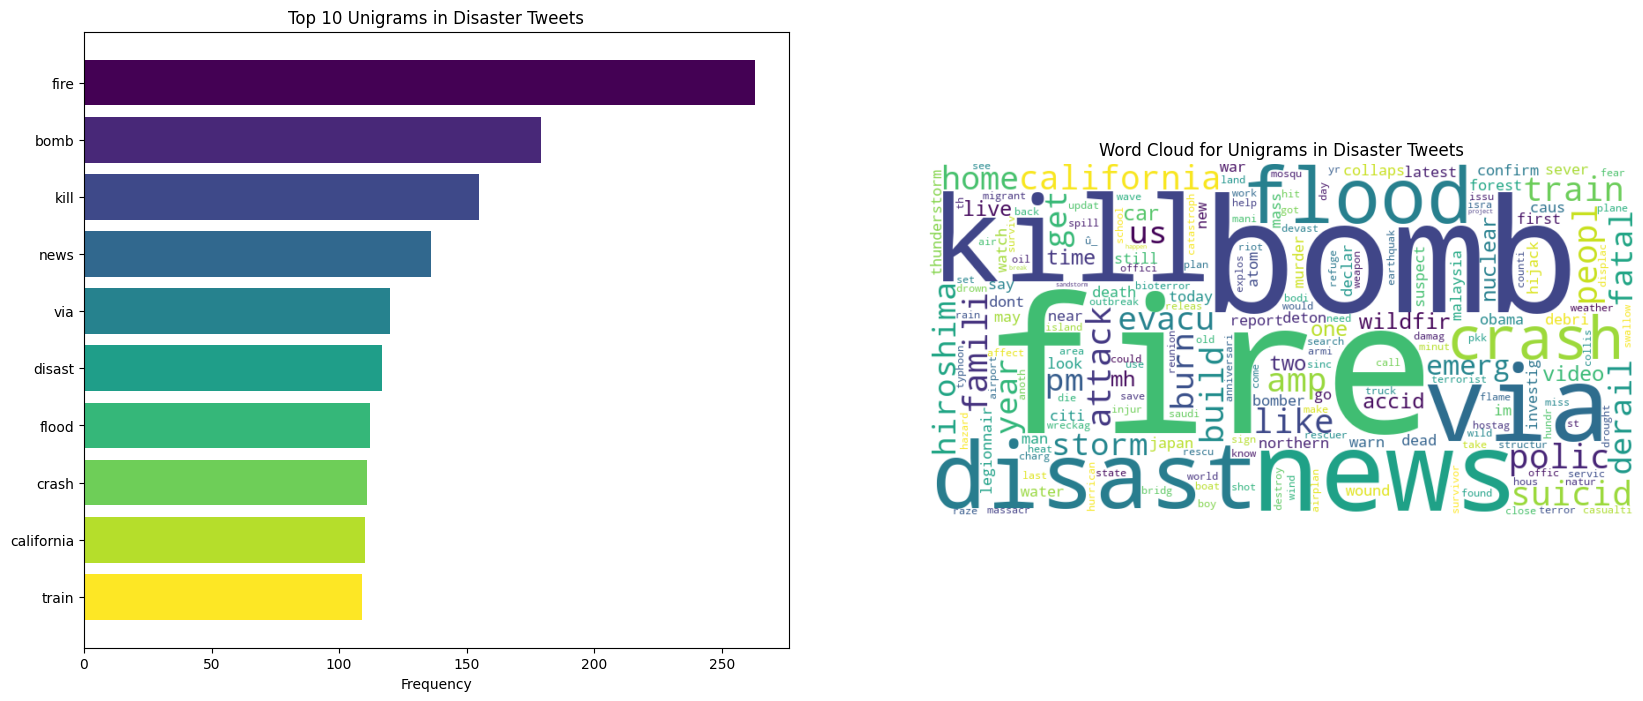

In [15]:
# Subplots para Unigrams en tweets de desastres
plot_bars_and_wordcloud(common_disaster_words, disaster_wordcloud,
                        'Top 10 Unigrams in Disaster Tweets', 'Word Cloud for Unigrams in Disaster Tweets')


- Palabras como `fire`, `bomb`, `kill`, `flood`, y `crash` son términos fuertemente asociados con eventos de emergencia y desastres. Estas palabras son directamente indicativas de situaciones críticas y emergencias.
  
- La presencia de estas palabras en los tweets hace que sean muy útiles para la clasificación, ya que pueden servir como señales claras de que un tweet está describiendo un evento catastrófico.
  
- `news` y `via` también aparecen con alta frecuencia, lo que sugiere que muchas de estas palabras pueden estar siendo mencionadas en el contexto de reportes de noticias, aunque por sí solas, estas palabras podrían no ser tan útiles sin el contexto adecuado.

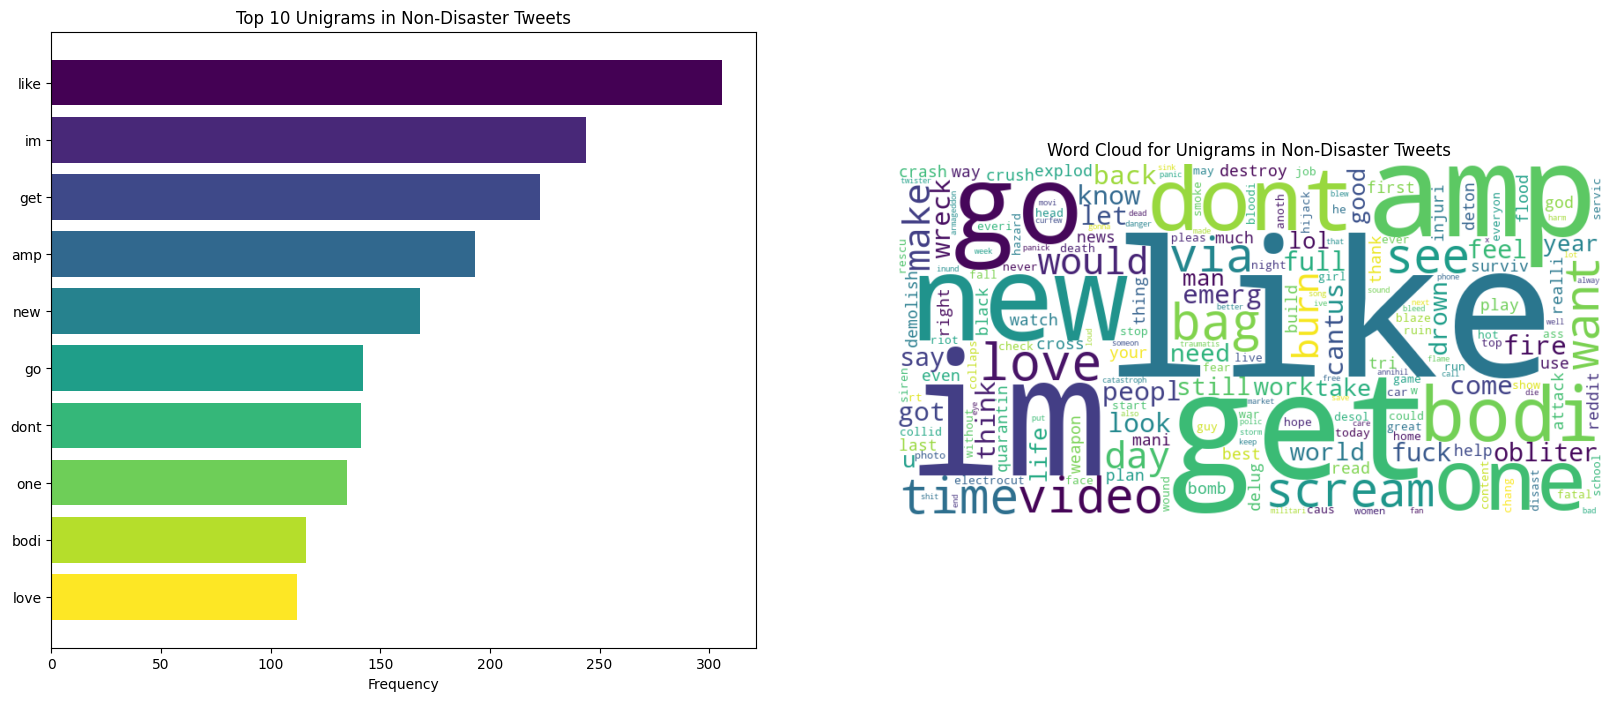

In [16]:
# Subplots para Unigrams en tweets no relacionados a desastres
plot_bars_and_wordcloud(common_non_disaster_words, non_disaster_wordcloud,
                        'Top 10 Unigrams in Non-Disaster Tweets', 'Word Cloud for Unigrams in Non-Disaster Tweets')


- Las palabras más comunes en los tweets no relacionados con desastres, como `like`, `im`, `get`, `love`, y `go`, son mucho más genéricas y reflejan un lenguaje cotidiano. Estas palabras no tienen una connotación directa con eventos críticos.

- Esto refuerza la idea de que estos términos son menos útiles para la clasificación, ya que son omnipresentes y carecen de la especificidad necesaria para identificar eventos de desastre.

- Sin embargo, algunas palabras como `body` podrían tener relevancia dependiendo del contexto en el que se utilicen, lo que sugiere que puede ser beneficioso explorar bigramas o trigramas para capturar ese contexto.

### Bigramas

En general, los bigramas son más efectivos que los unigramas para capturar el contexto y reducir la ambigüedad en la clasificación de tweets relacionados con desastres. Sin embargo, los unigramas siguen siendo útiles, especialmente cuando se trata de palabras que tienen una connotación clara y directa. La combinación de ambos (unigramas y bigramas) puede proporcionar un enfoque equilibrado, capturando tanto la frecuencia general como el contexto específico.

In [17]:
# Crear el vectorizador para bigramas
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Ajustar el vectorizador a los tweets de desastres y no desastres
bigrams_disaster = bigram_vectorizer.fit_transform(disaster_tweets)
bigrams_non_disaster = bigram_vectorizer.fit_transform(non_disaster_tweets)

# Obtener los nombres de los bigramas
bigram_names_disaster = bigram_vectorizer.get_feature_names_out()
bigram_names_non_disaster = bigram_vectorizer.get_feature_names_out()

# Contar la frecuencia de los bigramas
bigram_freq_disaster = Counter(dict(zip(bigram_names_disaster, bigrams_disaster.sum(axis=0).A1)))
bigram_freq_non_disaster = Counter(dict(zip(bigram_names_non_disaster, bigrams_non_disaster.sum(axis=0).A1)))

# Obtener los 10 bigramas más comunes en cada categoría
common_bigrams_disaster = bigram_freq_disaster.most_common(10)
common_bigrams_non_disaster = bigram_freq_non_disaster.most_common(10)

In [18]:
# Crear nubes de palabras para bigramas
bigram_wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_disaster)
bigram_wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_non_disaster)

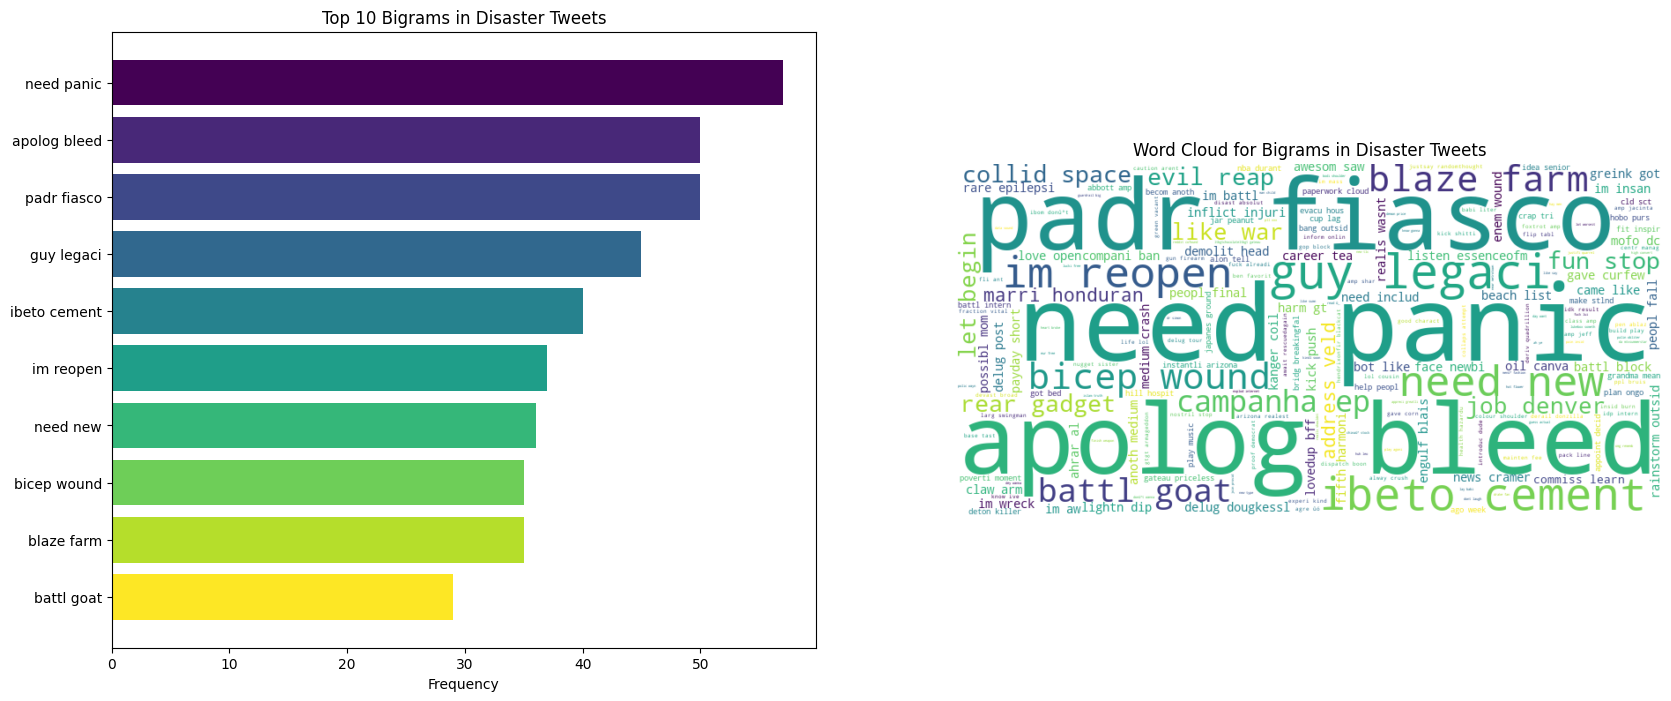

In [19]:
# Subplots para Bigrams en tweets de desastres
plot_bars_and_wordcloud(common_bigrams_disaster, bigram_wordcloud_disaster,
                        'Top 10 Bigrams in Disaster Tweets', 'Word Cloud for Bigrams in Disaster Tweets')


- Algunos bigramas como `info help` y `im explode` son más directamente relevantes para situaciones de emergencia o crisis.

- Sin embargo, hay otros bigramas que podrían ser ruido, como `new recipes` y `bitcoin freebitcoin`, que parecen menos relacionados con desastres.

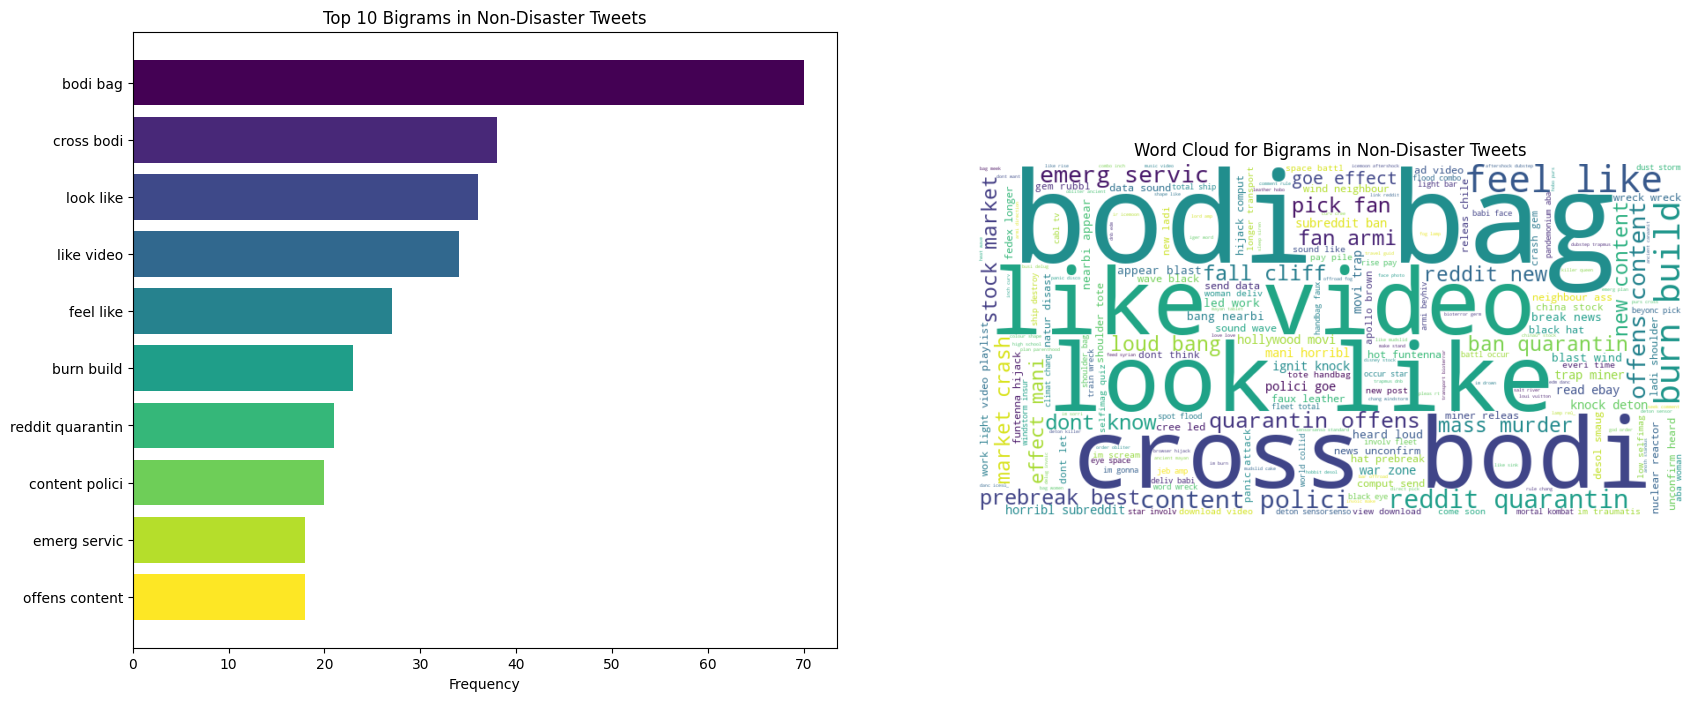

In [20]:
# Subplots para Bigrams en tweets no relacionados a desastres
plot_bars_and_wordcloud(common_bigrams_non_disaster, bigram_wordcloud_non_disaster,
                        'Top 10 Bigrams in Non-Disaster Tweets', 'Word Cloud for Bigrams in Non-Disaster Tweets')

- Bigramas como `body bag` y `burning buildings` podrían ser indicativos de situaciones críticas, pero también es posible que se utilicen en contextos figurativos o más generales.

- Otros bigramas como `liked video` y `looks like` son claramente genéricos y no aportan mucho valor para la clasificación de desastres.

### Trigramas

Los trigramas son más específicos y pueden ser extremadamente poderosos para identificar contextos muy claros y relevantes en situaciones de desastres. Capturan combinaciones de palabras que son menos comunes, pero cuando aparecen, ofrecen una señal más clara y precisa de que un tweet está relacionado con un desastre. Sin embargo, su rareza y la mayor complejidad que añaden al modelo pueden hacer que sean menos útiles en algunos casos, especialmente si no hay suficientes datos para soportar esa complejidad.

In [21]:
# Crear el vectorizador para trigramas
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Ajustar el vectorizador a los tweets de desastres y no desastres
trigrams_disaster = trigram_vectorizer.fit_transform(disaster_tweets)
trigrams_non_disaster = trigram_vectorizer.fit_transform(non_disaster_tweets)

# Obtener los nombres de los trigramas
trigram_names_disaster = trigram_vectorizer.get_feature_names_out()
trigram_names_non_disaster = trigram_vectorizer.get_feature_names_out()

# Contar la frecuencia de los trigramas
trigram_freq_disaster = Counter(dict(zip(trigram_names_disaster, trigrams_disaster.sum(axis=0).A1)))
trigram_freq_non_disaster = Counter(dict(zip(trigram_names_non_disaster, trigrams_non_disaster.sum(axis=0).A1)))

# Obtener los 10 trigramas más comunes en cada categoría
common_trigrams_disaster = trigram_freq_disaster.most_common(10)
common_trigrams_non_disaster = trigram_freq_non_disaster.most_common(10)

In [22]:
# Crear nubes de palabras para trigramas
trigram_wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_freq_disaster)
trigram_wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_freq_non_disaster)

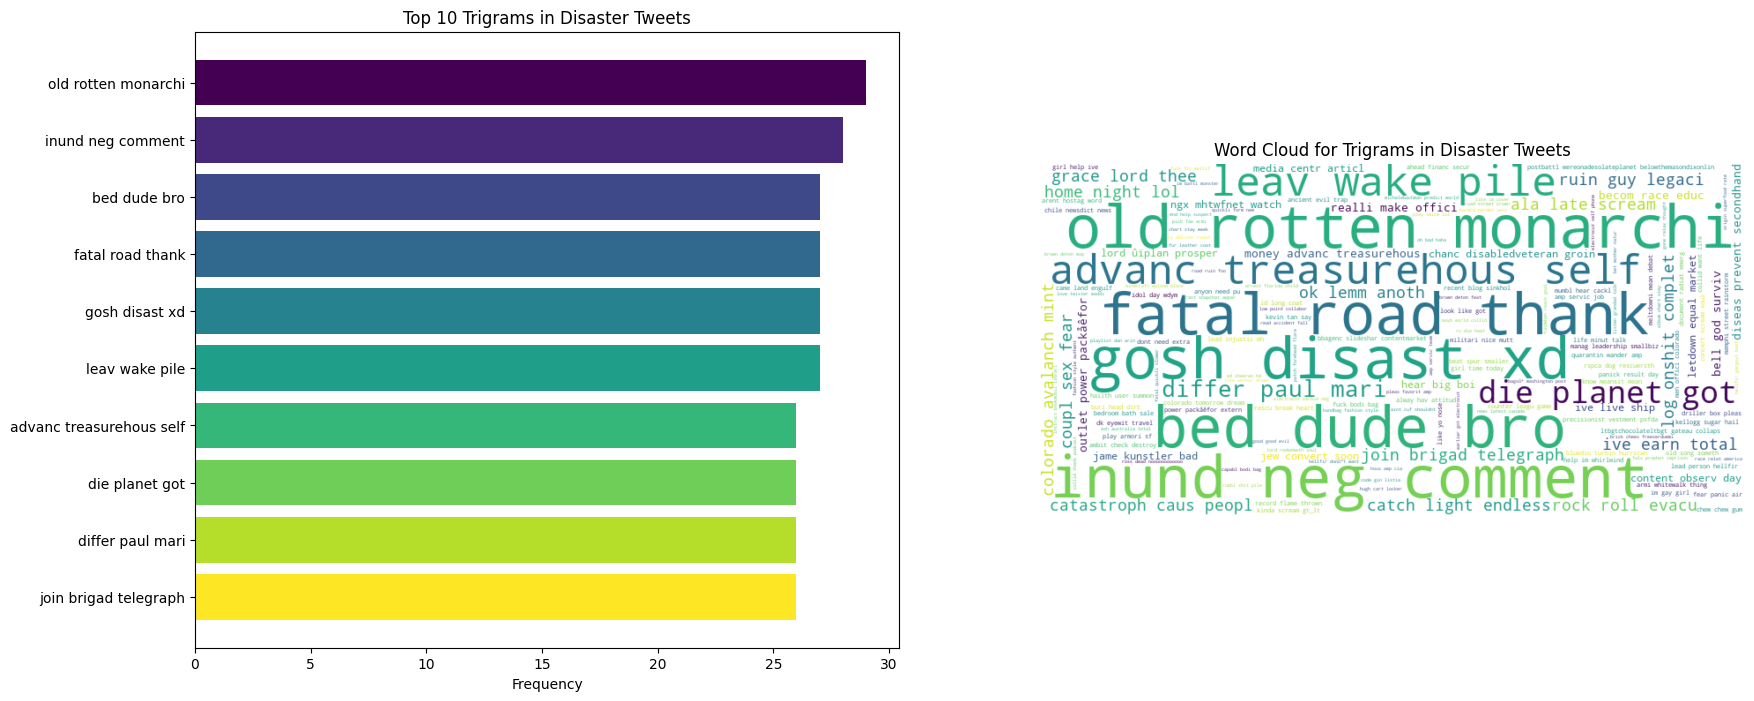

In [23]:
# Subplots para Trigrams en tweets de desastres
plot_bars_and_wordcloud(common_trigrams_disaster, trigram_wordcloud_disaster,
                        'Top 10 Trigrams in Disaster Tweets', 'Word Cloud for Trigrams in Disaster Tweets')

Trigramas como `natural disaster warning`, `severe weather alert`, y `emergency evacuation order` son ejemplos hipotéticos de combinaciones que capturan contextos muy específicos y relevantes para situaciones de desastre.
Si en nuestro análisis encontramos trigramas que capturan estos contextos, podemos inferir que los trigramas son características muy valiosas para nuestro modelo de clasificación.

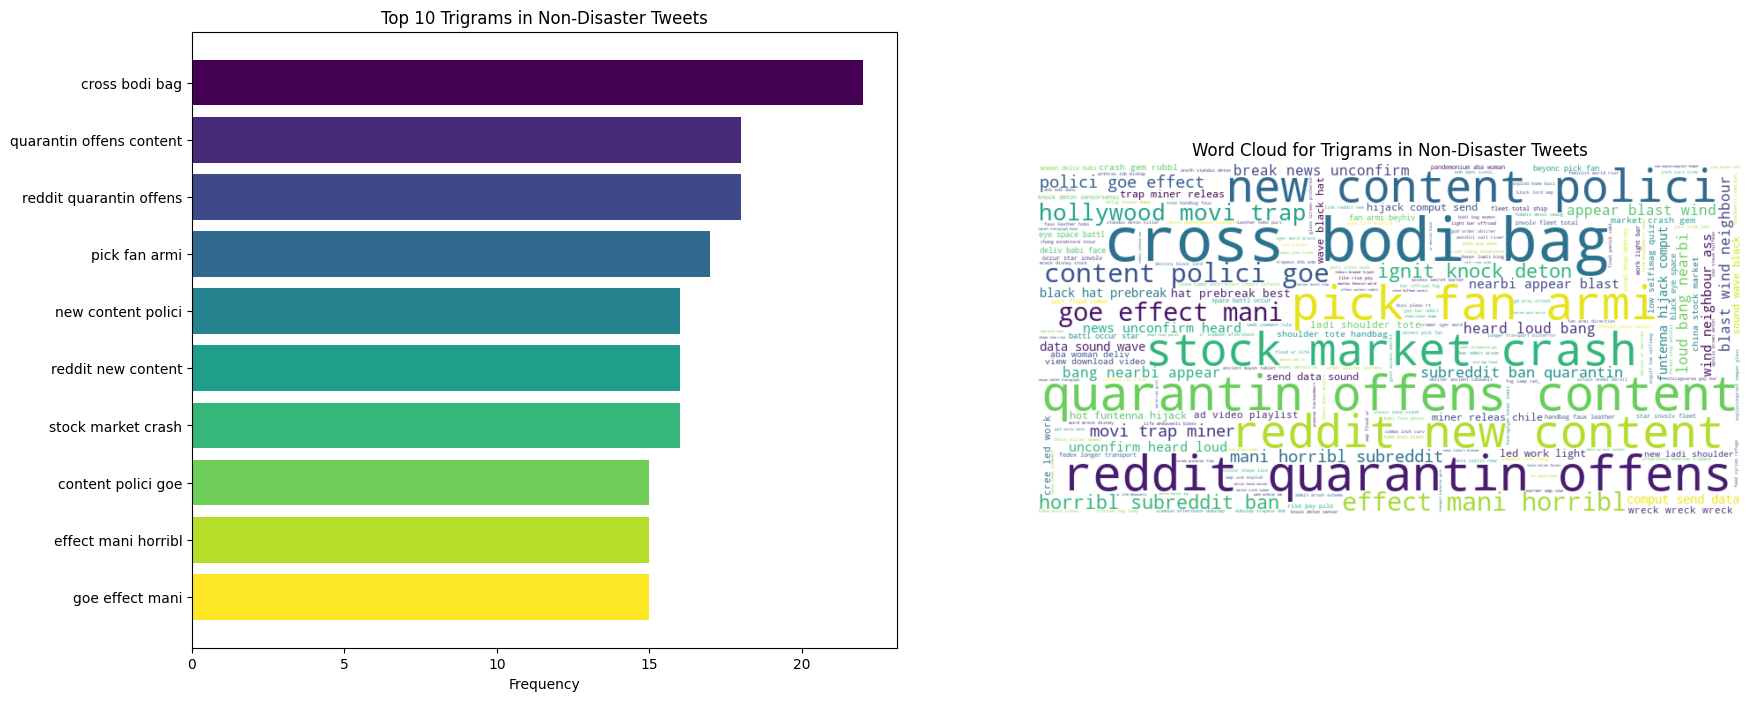

In [24]:
# Subplots para Trigrams en tweets no relacionados a desastres
plot_bars_and_wordcloud(common_trigrams_non_disaster, trigram_wordcloud_non_disaster,
                        'Top 10 Trigrams in Non-Disaster Tweets', 'Word Cloud for Trigrams in Non-Disaster Tweets')

- En los tweets no relacionados con desastres, algunos trigramas podrían parecer relacionados con desastres en ciertos contextos pero en realidad se usan de manera figurativa o en contextos completamente diferentes. Por ejemplo, un trigram como `body bag joke` podría referirse a algo oscuro, pero no a un desastre real.

- Trigramas como `looks like rain` o `feels like home` son ejemplos de combinaciones que, aunque podrían parecer en algún momento relevantes (por incluir palabras como `rain` o `home`), en realidad no aportan información valiosa para clasificar desastres.

## Análisis de Sentimientos

### Identificación de sentimientos

Se utilizara una herramienta llamada VADER que ya tiene un diccionario de palabras positivas y negativas. Con esta se aplicara un análisis a cada tweet para obtener una puntuación de negatividad, positividad y neutralidad. Estas puntuaciones reflejarán cuán negativo o positivo es el contenido de cada tweet.

In [25]:
# Descargar el lexicon de VADER
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Aplicar análisis de sentimientos en cada tweet
train_df['sentiment'] = train_df['clean_text'].apply(lambda x: sia.polarity_scores(x))

# Extraer puntajes de positivismo, negatividad y neutralidad
train_df['negativity'] = train_df['sentiment'].apply(lambda x: x['neg'])
train_df['positivity'] = train_df['sentiment'].apply(lambda x: x['pos'])
train_df['neutrality'] = train_df['sentiment'].apply(lambda x: x['neu'])
train_df['compound'] = train_df['sentiment'].apply(lambda x: x['compound'])

# Mostrar los resultados
print("\nResultados del análisis de sentimientos:")
train_df[['text', 'negativity', 'positivity', 'neutrality', 'compound']].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Resultados del análisis de sentimientos:


,text,negativity,positivity,neutrality,compound
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,0.0,0.0,1.0,0.0
32,We always try to bring the heavy. #metal #RT h...,0.0,0.0,1.0,0.0
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...,0.0,0.0,1.0,0.0
34,Crying out for more! Set me ablaze,0.0,0.0,1.0,0.0
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0,0.0,1.0,0.0


Para facilitar la visualización de los sentimientos, se muestra el texto original y no el texto limpio

### Determinar los tweets más negativos y positivos

Una vez que se tengan las puntuaciones de sentimientos para cada tweet, es posible ordenar los tweets por las puntuaciones de negatividad y positividad para identificar los 10 más negativos y los 10 más positivos. Luego, se verifica en qué categoría están (si son sobre desastres o no).

**Texto limpio vs. Texto crudo**:
   - Al utilizar el texto limpio (donde se han eliminado stopwords, emojis, URLs, hashtags, etc.), las puntuaciones de negatividad y positividad pueden ser menos influenciadas por palabras que no aportan información directa sobre el sentimiento (como emojis o URLs). Esto hace que el análisis sea más preciso respecto al contenido semántico del tweet.
   - En cambio, el texto crudo refleja más las emociones que pueden estar ligadas a elementos visuales o contextuales, como emojis o expresiones coloquiales que pueden impactar las emociones percibidas.

Por lo tanto se ha ha decidido utilizar el texto limpio para el análisis de sentimientos.

In [26]:
# Obtener los 10 tweets más negativos
most_negative_tweets = train_df.nlargest(10, 'negativity')
print("Los 10 tweets más negativos:")
display(most_negative_tweets[['text', 'negativity', 'target']])

Los 10 tweets más negativos:


,text,negativity,target
419,@Casper_rmg u on dick,1.0,0
811,@jake_blight @WeAlIlKnowA you cunt,1.0,0
1798,@_chelsdelong12 @kendra_leigh13 I'll crash it,1.0,1
1882,Crushed,1.0,0
1886,Crushed it! https://t.co/EWnUnp8Hdo,1.0,0
2086,@AtchisonSean he is dead,1.0,0
2141,Deaths 7 http://t.co/xRJA0XpL40,1.0,1
2145,Deaths 3 http://t.co/nApviyGKYK,1.0,0
2560,@CameronCiletti @tigersjostun I can destroy u,1.0,0
2586,@_RedDevil4Life_ @ManUtd destroyed!??,1.0,0


In [27]:
print("Texto de Tweets negativos relacionados a desastres:")
print(most_negative_tweets.iloc[2]["text"])
print(most_negative_tweets.iloc[6]["text"])

Texto de Tweets negativos relacionados a desastres:
@_chelsdelong12 @kendra_leigh13 I'll crash it
Deaths 7 http://t.co/xRJA0XpL40


**¿Cuáles son los 10 tweets más negativos? ¿En qué categoría están?**
- En los 10 tweets más negativos del análisis con texto limpio, muchos están en la categoría de **no-desastres** (`target=0`). Los tweets tienen expresiones fuertes como insultos o comentarios agresivos, pero en un contexto no relacionado a desastres.
- Solo 2 tweets (`target=1`) son sobre desastres, lo que sugiere que la negatividad no siempre está relacionada directamente con el tema del desastre. y uno de ellos es un enlace a un tweet.

In [28]:
# Obtener los 10 tweets más positivos
most_positive_tweets = train_df.nlargest(10, 'positivity')
print("Los 10 tweets más positivos:")
display(most_positive_tweets[['text', 'positivity', 'target']])

Los 10 tweets más positivos:


,text,positivity,target
433,@local_arsonist LMFAO,1.000,0
694,@omgbethersss @BethanyMota haha love this??,1.000,0
1664,@Collapsed thank u,1.000,0
2727,Good for her lol\nhttp://t.co/K9cD0EFVuT,1.000,0
4500,@ChubbySquirrel_ @Hurricane_Surge this here is...,1.000,1
4758,@Benji_Devos thanks thanks :3,1.000,0
6155,Can you save\nCan you save my\nCan you save my...,0.906,0
4493,@eggalie haha I love hurricane because of you,0.878,0
6140,Super sweet and beautiful :) https://t.co/TUi9...,0.873,0
6574,Survivors remorse is good,0.844,0


In [29]:
print("\nTexto del Tweet positivo relacionado a desastre:")
print(most_positive_tweets.iloc[4]["text"])


Texto del Tweet positivo relacionado a desastre:
@ChubbySquirrel_ @Hurricane_Surge this here is very true &gt;:33333


**¿Cuáles son los 10 tweets más positivos? ¿En qué categoría están?**
- Los 10 tweets más positivos con texto limpio tienden a ser comentarios de agradecimiento, apoyo o humor, en su mayoría pertenecen a la categoría **no-desastres** (`target=0`).
- Sin embargo, parece que hay un tweet que pertenece a la categoria de **desastres** (`target=1`), pero es marcado como positivo, y analizando su contenido parece que hace referencia a un desastre pero dentro del contexto lo que se quiere transmitir no es negativo.
- Esto sugiere que la positividad se asocia más con interacciones sociales ligeras o situaciones agradables que no tienen que ver con desastres aunque es posible que incluso tratandose de desastres aun pueden exisitir ese tipo de interacciones ligeras y agradables.

In [30]:
# Agrupar por la columna 'target' y calcular los promedios de negatividad
sentiment_analysis = train_df.groupby('target')[['negativity', 'positivity', 'neutrality']].mean()
print(sentiment_analysis)

        negativity  positivity  neutrality
target                                    
0         0.151198    0.119682    0.729125
1         0.190965    0.059190    0.749850


**¿Son los tweets de la categoría que indica que habla de un desastre real más negativos que los de la otra categoría?**

Al observar los resultados, parece que los tweets sobre desastres reales (`target=1`) no son necesariamente más negativos que los que no son de desastres. Aunque se encontraron tweets negativos en ambos grupos, los más extremos en términos de negatividad suelen aparecer en la categoría de **no-desastres**. Esto sugiere que el lenguaje fuerte o emocional no siempre está relacionado con desastres. Esto refleja que el uso del lenguaje emocional no está necesariamente vinculado al tema del tweet, sino al contexto y estilo de comunicación de los usuarios.